Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

## Colab

## Imports

In [1]:
! pip install torchdiffeq

  Using cached scipy-1.8.0-cp39-cp39-win_amd64.whl (36.9 MB)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time

In [3]:
# set device to GPU if available otherwise use CPU
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Device Availble: {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

device = set_device()

cpu


## Data Generation

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

### Plot functions for data

In [4]:
def plot_traj_furuta(t_eval, q1, p1, q2, p2, energy=torch.tensor(False),
                     title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns
    if torch.any(energy):
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(15, 4),constrained_layout=True, sharex=True)# , sharey=True)
        ax5.plot(t_eval, energy, label='energy')

        # ax1.legend()
        ax5.set_title('Energy', fontsize=10)
        ax5.set_xlabel('time (s)')
        ax5.set_ylabel('E')
        ax5.set_ylim((0,torch.max(energy)*1.1))
    else:
       fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q1, label='q1')
    ax2.plot(t_eval, p1, label='p1')
    ax3.plot(t_eval, q2, label='q2')
    ax4.plot(t_eval, p2, label='p2')

    #ax1.legend()
    ax1.set_title('generalized position (q1)', fontsize=10)
    ax1.set_xlabel('time[s]')
    ax1.set_ylabel('q1[rad]')

    #ax2.legend()
    ax2.set_title('generalized momentum (p1)', fontsize=10)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('p1')

    ax3.set_title('generalized position (q2)', fontsize=10)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('q2[rad]')

    ax4.set_title('generalized momentum (p2)', fontsize=10)
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('p2')
    
    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q1}[rad/s]$')
        ax4.set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax4.set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return

### Dynamics

In [5]:
def furuta_H(q1,p1,q2,p2):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    ''' 

    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp

    # hamiltonian function
    H = p1**2 * (C1+C2*torch.sin(q1)**2 )+ C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)**2 - (C3**2) * (torch.cos(q1)**2)) 
    H = H + C5*(torch.cos(q1)+1)

    return H
    
def hamiltonian_fn_furuta(coords):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1,p1,q2,p2 = torch.split(coords,1)

    H = furuta_H(q1,p1,q2,p2)
    return H

def coord_derivatives_furuta(coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (default=0.0, float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (default=0.0, float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad=True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords)

    # gradient of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True) # !! might need to add H.sum() if batches used here later

    dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)

    dq1dt = dHdp1
    dp1dt = -dHdq1 -C_q1*dHdp1
    dq2dt = dHdp2
    dp2dt = -dHdq2 -C_q2*dHdp2

    return dq1dt, dp1dt, dq2dt, dp2dt
    
def dynamics_fn_furuta(t, coords, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u, C_q1,
                                                          C_q2)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S

### Trajectory

In [6]:
def random_uniform_two_interval():
    '''
      return x taken from a uniform distribution in one of two intervals 
      [-2,-0.3] or [0.3,2]
    Input : 
      None
    Outputs

    '''
    if torch.tensor([0.5]).bernoulli().bool():
        x = torch.zeros(1).uniform_(0.3,2)
    else:
        x = torch.zeros(1).uniform_(-2,-0.3)
    return x

In [7]:
def get_init_state():
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition
      
    '''
    y0 = torch.zeros(4)

    y0[0] = random_uniform_two_interval() 
    y0[2] = random_uniform_two_interval()

    y0[1]=0.0 # p1 = 0
    y0[3]=0.0 # p2 = 0
    return y0

In [8]:
def get_trajectory_furuta(timesteps=20, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''

    Ts = 0.005 # sampling time 
    t_eval = torch.linspace(1, timesteps, timesteps) * Ts # evaluated times vector
    t_span = [Ts, timesteps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state()

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, u, C_q1, C_q2), 
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts)) 

    q1, p1, q2, p2 = torch.chunk(q_p, 4, 1) 

    # add noise 
    q1 = (q1+torch.randn(q1.shape)*noise_std).detach().squeeze()
    p1 = (p1+torch.randn(p1.shape)*noise_std*torch.max(p1)).detach().squeeze()
    q2 = (q2+torch.randn(q2.shape)*noise_std).detach().squeeze()
    p2 = (p2+torch.randn(p2.shape)*noise_std*torch.max(p2)).detach().squeeze()
    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    return q1, p1, q2, p2, t_eval.detach()

In [ ]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=10000, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.000009, C_q2=0.00004)


In [ ]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=400, y0=None, noise_std=0.0, 
                   u=0.0)#, C_q1=0.000009, C_q2=0.00004)

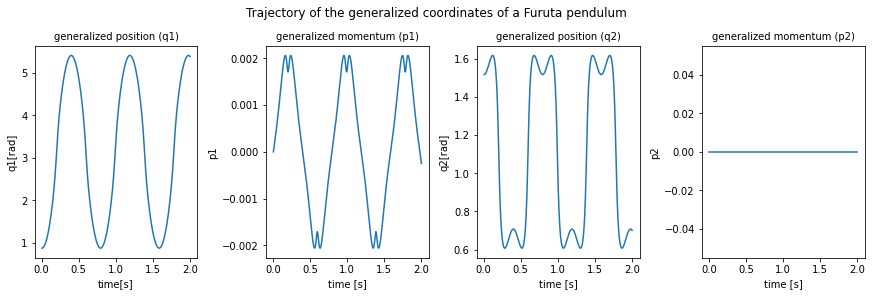

In [ ]:
plot_traj_furuta(t_eval, q1, p1, q2, p2, title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

### Energy

In [9]:
def energy_furuta(dq1dt,dq2dt,q1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # system constants
    g = 9.81
    Jr = 5.72*1e-5
    Lr = 0.085
    Mp = 0.024
    Lp = 0.129
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp
    
    E = (1/2)* dq2dt**2 * (C1+C2*torch.sin(q1)**2)+ dq2dt*dq1dt*C3*torch.cos(q1)
    E = E +(1/2)*dq1dt**2 *C4+C5*torch.cos(q1)+C5

    return E

def get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, p1, q2, p2),dim=1):

      dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(coords, u,
                                                            C_q1, C_q2)

      q1_n = coords[0]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n))
      derivatives.append(torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt)))
 
    energy = torch.hstack(energy).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

In [10]:
### NOT TESTED
def get_energy_furuta_newtonian(q1, dq1dt, q2, dq2dt, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, dq1dt, dq2dt),dim=1):

      q1_n = coords[0]
      dq1dt = coords[1]
      dq2dt = coords[2]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n))

    energy = torch.hstack(energy).detach()
    return energy

### Multiple trajectories

In [11]:
def multiple_trajectories_furuta(time_steps, num_trajectories, 
                          y0=torch.tensor([1.0,0.0,1.0,0.0]),
                          noise_std=0.0, u=0, C_q1=0.0, C_q2=0.0):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # the first trajectory
    q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=time_steps, 
                                                   y0=y0, noise_std=noise_std, 
                                                   u=u, C_q1=C_q1, C_q2=C_q2)
    
    energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=u, C_q1=C_q1, C_q2=C_q2)
    derivatives = derivatives.unsqueeze(dim=0)
    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q1_n, p1_n, q2_n, p2_n, t_eval_n = get_trajectory_furuta(
                     timesteps=time_steps, y0=y0, noise_std=noise_std, u=u, C_q1=0.0, C_q2=0.0)
        energy_n, derivatives_n = get_energy_furuta(q1_n, p1_n, q2_n, p2_n, u=u, C_q1=C_q1, C_q2=C_q2)

        q1 = torch.vstack((q1, q1_n))
        p1 = torch.vstack((p1, p1_n))
        q2 = torch.vstack((q2, q2_n))
        p2 = torch.vstack((p2, p2_n))

        
        energy = torch.vstack((energy, energy_n))
        derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))
        # t_eval = torch.vstack((t_eval, t_eval_n))
      
    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q1 = q1.unsqueeze(dim=0)
        p1 = p1.unsqueeze(dim=0)
        q2 = q2.unsqueeze(dim=0)
        p2 = p2.unsqueeze(dim=0)

        energy = energy.unsqueeze(dim=0)
        derivatives = derivatives

        #t_eval = t_eval.unsqueeze(dim=0)
    return q1, p1, q2, p2, energy, derivatives, t_eval

In [ ]:
derivatives.shape

torch.Size([100, 4])

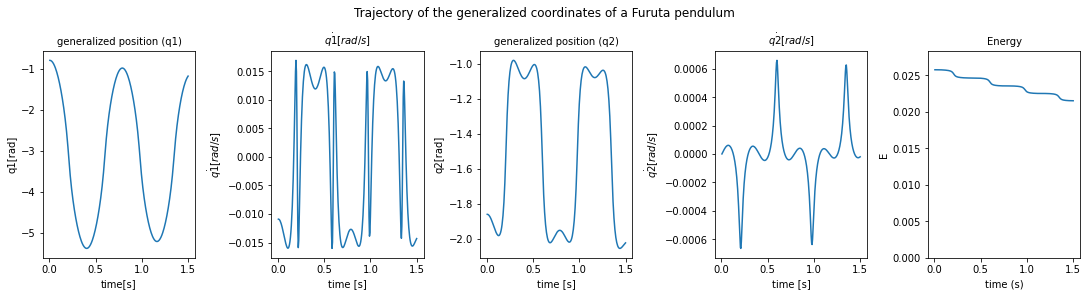

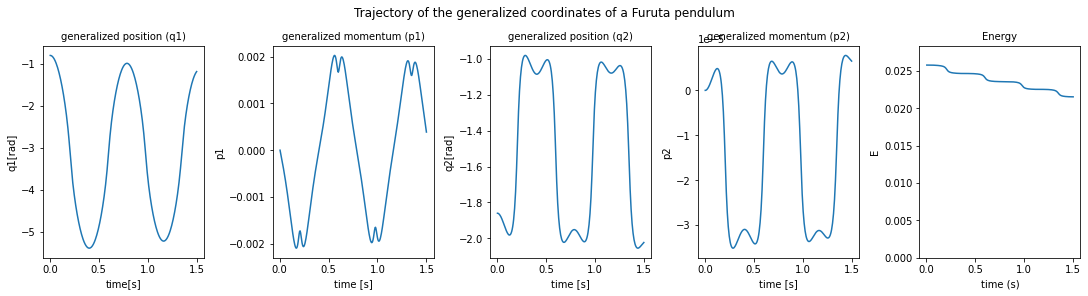

In [ ]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=300, y0=None, noise_std=0.0, 
                   u=0.0, C_q1=0.000009, C_q2=0.00004)
energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.000009, C_q2=0.00004)

plot_traj_furuta(t_eval, q1, derivatives[:,1], q2, derivatives[:,3], energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

In [ ]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(timesteps=200, y0=torch.tensor([1.0,0.0,0.0,0.0]), noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)
energy, derivatives = get_energy_furuta(q1, p1, q2, p2, u=0, C_q1=0.0, C_q2=0.0)

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

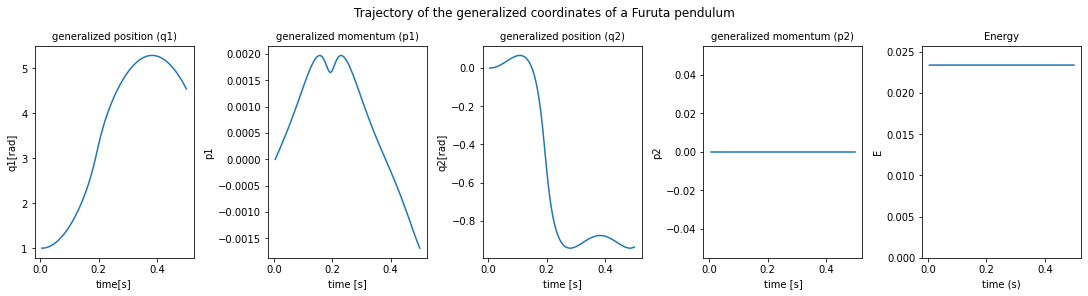

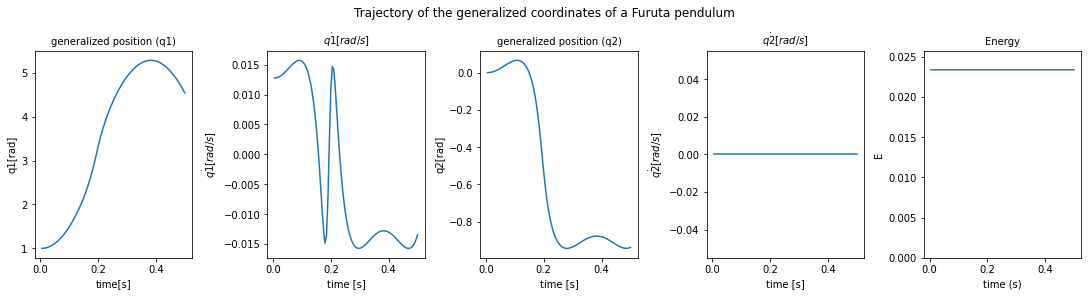

In [ ]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=100, num_trajectories=3, y0=torch.tensor([1.0,0.0,0.0,0.0]), noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)

plot_traj_furuta(t_eval, q1[0,:], p1[0,:], q2[0,:], p2[0,:], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

plot_traj_furuta(t_eval, q1[0,:], derivatives[0,:,1], q2[0,:], derivatives[0,:,3], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

In [ ]:

print(q1.shape)
print(energy.shape)
print(derivatives.shape)
print(t_eval.shape)

torch.Size([3, 100])
torch.Size([3, 100])
torch.Size([3, 100, 4])
torch.Size([100])


### Dataset & Dataloader

In [12]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    def __init__(self, q1, p1, q2, p2, t_eval, #energy=torch.tensor(False), 
                 derivatives, coord_type='hamiltonian' ):
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1
        self.p1 = p1
        self.q2 = q2
        self.p2 = p2
        # if energy:
        #    self.energy = energy
        #if derivatives:
        self.dq1dt = derivatives[:,:,0]
        #self.dp1dt = derivatives[:,:,1]
        self.dq2dt = derivatives[:,:,2]
        #self.dp2dt = derivatives[:,:,4]
        
    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):
        
        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            
            x = torch.vstack((q1,p1,q2,p2))
            
        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]
            
            x = torch.vstack((q1,dq1dt,q2,dq2dt))
            
        t_eval = self.t_eval

        return x, t_eval

In [13]:
def data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.5, coord_type='newtonian'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # split  into train and test 
    full_dataset = TrajectoryDataset_furuta(q1, p1, q2, p2, t_eval,derivatives, coord_type=coord_type)
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
            )    
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

In [36]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, 
                   num_trajectories=10, y0=torch.tensor([1.0,0.0,0.0,0.0]), noise_std=0.0, 
                   u=0.0, C_q1=0.0, C_q2=0.0)

train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=3,
                       shuffle = True, proportion = 0.5, coord_type='newtonian')

In [37]:
energy.shape

torch.Size([10, 300])

torch.Size([3, 4, 300])


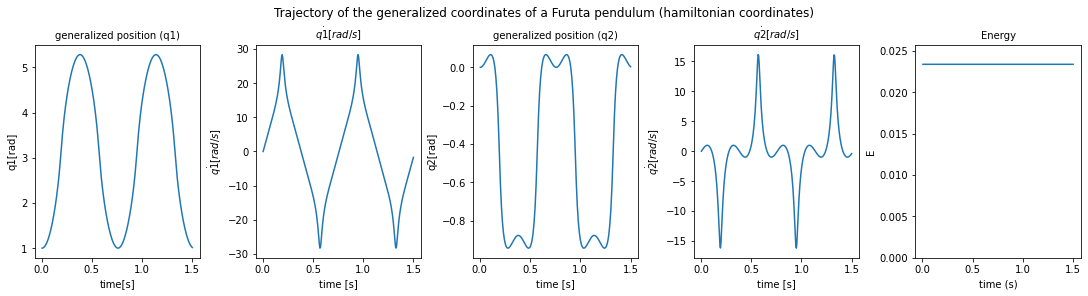

In [38]:
# sanity checks
x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)

q1_t = x_tt[0,0,:]
p1_t = x_tt[0,1,:]
q2_t = x_tt[0,2,:]
p2_t = x_tt[0,3,:]

plot_traj_furuta(t_eval_tt[0], q1_t, p1_t, q2_t, p2_t,energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='newtonian')

## Utils

In [14]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:
      
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Plot functions for train & test

In [15]:
def plot_furuta_hat_nom(data_loader_t,t_max,
                     title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                     , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    x_nom, t_eval = next(iter(data_loader_t))
    # predicted trajectory
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[:,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[:,0,1]
    q2_hat = x_hat[:,0,2]
    p2_hat = x_hat[:,0,3]

    E_hat, _ = get_energy_furuta(q1_hat, p1_hat, q2_hat, p2_hat, u=0, C_q1=0.0, C_q2=0.0)
    H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()

    # nominal trajectory
    q1_nom = x_nom[0,0,:]
    p1_nom = x_nom[0,1,:]
    q2_nom = x_nom[0,2,:]
    p2_nom = x_nom[0,3,:]

    E_nom, _ = get_energy_furuta(q1_nom, p1_nom, q2_nom, p2_nom, u=0, C_q1=0.0, C_q2=0.0)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom)

    t_eval = t_eval[0,:] # otherwise it is by batch


    fig, ax = plt.subplots(2, 3, figsize=(15, 4), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)
    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        ax[0,0].plot(t_eval[:t_max], q1[:t_max], label='train', c='g')
        ax[0,0].plot(t_eval[t_max:], q1[t_max:], label=label, c='r')

        ax[1,0].plot(t_eval[:t_max], p1[:t_max], label='train', c='g')
        ax[1,0].plot(t_eval[t_max:], p1[t_max:], label=label, c='r')

        ax[0,1].plot(t_eval[:t_max], q2[:t_max], label='train', c='g')
        ax[0,1].plot(t_eval[t_max:], q2[t_max:], label=label, c='r')

        ax[1,1].plot(t_eval[:t_max], p2[:t_max], label='train', c='g')
        ax[1,1].plot(t_eval[t_max:], p2[t_max:], label=label, c='r')

        ax[0,2].plot(t_eval[:t_max], H[:t_max], label='train', c='g')
        ax[0,2].plot(t_eval[t_max:], H[t_max:], label=label, c='r')

        ax[1,2].plot(t_eval[:t_max], E[:t_max], label='train', c='g')
        ax[1,2].plot(t_eval[t_max:], E[t_max:], label=label, c='r')



    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, H, label=label)
        ax[1,2].plot(t_eval, E, label=label)


    for j in range(3): # show all of the legends
      for i in range(2):
        ax[i,j].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')

    ax[0,2].set_title('Energy', fontsize=10)
    ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    ax[1,2].set_title('Hamiltonian', fontsize=10)
    ax[1,2].set_xlabel('time (s)')
    ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

In [16]:
def plot_longer_horizon_furuta(test_loader,t1,t2, title = 'Trajectory after longer horizon', file_path=None):
    '''

    Description:

    Inputs:

    Outpus:
      
    '''
    x_nom, t_eval = next(iter(test_loader))

    # test trajectories
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[t1:t2,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[t1:t2,0,1]
    q2_hat = x_hat[t1:t2,0,2]
    p2_hat = x_hat[t1:t2,0,3]

    E_hat, _ = get_energy_furuta(q1_hat, p1_hat, q2_hat, p2_hat, u=0, C_q1=0.0, C_q2=0.0)
    H_hat = model.H_net(x_hat[t1:t2,0,:]).detach().squeeze()

    # nominal trajectories
    q1_nom = x_nom[0,0,t1:t2]
    p1_nom = x_nom[0,1,t1:t2]
    q2_nom = x_nom[0,2,t1:t2]
    p2_nom = x_nom[0,3,t1:t2]

    E_nom, _ = get_energy_furuta(q1_nom, p1_nom, q2_nom, p2_nom, u=0, C_q1=0.0, C_q2=0.0)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom)

    t_eval = t_eval[0,t1:t2]

    fig, ax = plt.subplots(2, 2, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction'],[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)

        ax[1,0].plot(t_eval, E, label=label)
        ax[1,0].set_title('Energy', fontsize=10)
        ax[1,0].set_xlabel('time (s)')
        ax[1,0].set_ylabel('E')
          
        ax[1,1].plot(t_eval, H, label=label)
        ax[1,1].set_title('Hamiltonian', fontsize=10)
        ax[1,1].set_xlabel('time (s)')
        ax[1,1].set_ylabel('H')

    #ax[1,0].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    for j in range(2): # show all of the legends
      for i in range(2):
        ax[i,j].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')
    fig.suptitle(title, fontsize=12)
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return 

In [17]:
def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    fig, ax = plt.subplots(figsize=(10,4))#,constrained_layout=True)
    #fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')
    plt.plot(epochs[::10], loss_test, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title('train and test loss per epoch')
    horizons = [100,150,200,250,300]
    horizon_steps = [200,400,550,700,850]
    for i, epoch_num in enumerate(horizon_steps[:-1]):
        ax.annotate(
        'horizon = %d'%horizons[i],
        xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
        xytext=(-70, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))
    ax.annotate(
    'horizon = %d'%horizons[-1],
    xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
    xytext=(+20, 100), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    #connectionstyle="arc,angleA=0,armA=50,rad=10"
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"
                    ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

In [168]:
horizon_steps = [200,400,550,700,800]
horizon_steps[:-1]

[200, 400, 550, 700]

## Models

### Base models

In [18]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

In [19]:
class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x

In [20]:
class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x, separate_fields=False):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

### MLP_U_HNN

In [21]:
class Simple_MLP(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, input_dim, H_net=None, device=None):
        super(Simple_MLP, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 # - self.C1_dissip*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 # - self.C2_dissip*dHdp2

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 

            return S_h

In [22]:
H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
count_parameters(H_net)

33301

### Autoencoder (not finished)

In [23]:
class Autoencoder(torch.nn.Module):
    '''
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=2, dec_in_dim = 2, dec_out_dim = 2, activation='tanh'):
        super(Autoencoder, self).__init__()

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)
        # q,p=torch.split(x,1,dim=2)
        p_hat = self.encoder(x) # coordinates in the latent space

        # z_h = torch.cat((q,z),dim=2) # input known q and encoded z into decoder
        q_dot_hat = self.decoder(p_hat) # coordinates back in the original space but using the decoder

        return p_hat, q_dot_hat

In [ ]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, enc_in_dim=2, 
                 enc_out_dim=1, dec_in_dim = 1, dec_out_dim = 2, activation='tanh')

In [ ]:
count_parameters(autoencoder)

### Train functions

In [24]:
def L2_loss(u, v, w):
    return ((u-v)*w).pow(2).mean()

In [25]:
def load_model():
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model 

In [26]:
def load_data_device(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                      num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                      u=0.0,C_q1=0.0, C_q2=0.0)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)

    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader

#### Horizon method : Jonas

In [27]:
def select_horizon(step, 
                   n1=200, 
                   n2=200, 
                   n3=150,
                   n4=150,
                   n5=150):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 
    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
    else :
        horizon = 300
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
    return horizon

In [28]:
def train(model, epochs = 20):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3
    Ts = 0.005
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    w=torch.tensor([0.1,0.1,1.0,1.0], device=device)

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()
        horizon = select_horizon(step)
        # horizon = -1
        for x, t_eval in iter(train_loader):
            
            t_eval = t_eval[0,:horizon]

            train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            

            train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss = train_loss + train_loss_mini

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:horizon]
   
                    test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')      
                    test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                    test_loss = test_loss + test_loss_mini
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss.item(), test_loss.item(),test_time))
                stats['test_loss'].append(test_loss.item())
                
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                      .format(step, train_time, train_loss.item()))
        
        # logging
        stats['train_loss'].append(train_loss.item())
        
    return stats

##### Training

In [29]:
# device = 'cpu' # for some reason the training loop is quicker on CPU
# maybe because of how odeint solves the diff eqs ?

In [46]:
model = load_model()
count_parameters(model)

33303

In [48]:
train_loader, test_loader = load_data_device(time_steps=300, num_trajectories=125, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.8, batch_size=100)

In [198]:
# train_loader, test_loader = load_data_device(time_steps=50, num_trajectories=125, 
#                                              C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.8, batch_size=100)

In [ ]:
stats = train(model, epochs = 1000)

horizon length : 50
epoch    0 | train time 0.67 | train loss 4.783462e-02 | test loss 4.846905e-02 | test time 0.34  
epoch    1 | train time 0.67 | train loss 4.607708e-02 
epoch    2 | train time 0.68 | train loss 4.389914e-02 
epoch    3 | train time 0.68 | train loss 4.113819e-02 
epoch    4 | train time 0.67 | train loss 3.779197e-02 
epoch    5 | train time 0.68 | train loss 3.402635e-02 
epoch    6 | train time 0.68 | train loss 3.014059e-02 
epoch    7 | train time 0.67 | train loss 2.646639e-02 
epoch    8 | train time 0.69 | train loss 2.332770e-02 
epoch    9 | train time 0.77 | train loss 2.112408e-02 
epoch   10 | train time 0.68 | train loss 2.032605e-02 | test loss 2.004244e-02 | test time 0.34  
epoch   11 | train time 0.67 | train loss 2.070693e-02 
epoch   12 | train time 0.69 | train loss 2.064261e-02 
epoch   13 | train time 0.69 | train loss 1.984211e-02 
epoch   14 | train time 0.69 | train loss 1.884988e-02 
epoch   15 | train time 0.68 | train loss 1.790794e-02

##### Saving stats and model to disk

In [179]:
# Mount your google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
## saving stats to txt file
import json
PATH = './drive/MyDrive/1_SP_Ham_func/'
suffix = '27_03'
stats_path = PATH+'stats/stats'+suffix+'.txt'
with open(stats_path, 'w') as file:
     file.write(json.dumps(stats)) # use `json.loads` to do the reverse

In [181]:
import json

PATH = './drive/MyDrive/1_SP_Ham_func/'
suffix = '27_03'
stats_path = PATH+'stats/stats'+suffix+'.txt'

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

save_stats(PATH, stats, stats_path)

In [192]:
def read_dict(PATH, stats_path):
    # read the stats txt file
    with open(stats_path) as f:
        data = f.read()

    data = json.loads(data)
    return data
    
stats = read_dict(PATH, stats_path)

In [191]:
# save model to disk
model_name = 'models/model_test'
torch.save(model.state_dict(), PATH+model_name)

In [165]:
# load model from disk
model = load_model()
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

Simple_MLP(
  (H_net): MLP(
    (fc1): Linear(in_features=4, out_features=90, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (1): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (2): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (3): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
    )
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  )
)

##### Plots of training results

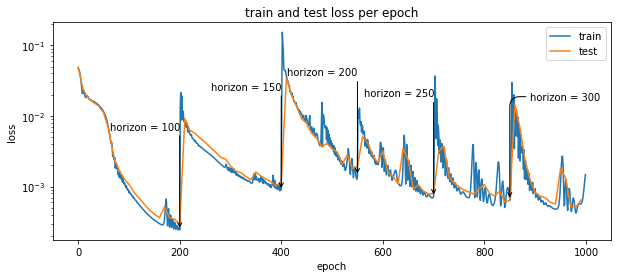

In [186]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(1000)
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'img/train_test_loss.png')

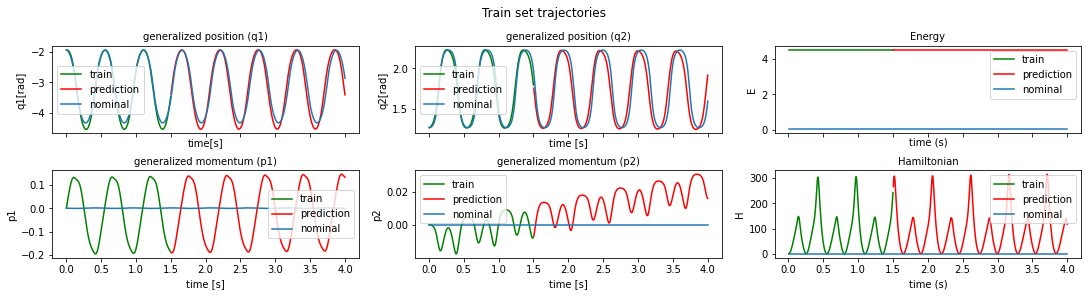

In [187]:
plot_furuta_hat_nom(train_loader, t_max=300,
                     title = 'Train set trajectories', file_path=PATH+'img/train_set_traj.png')

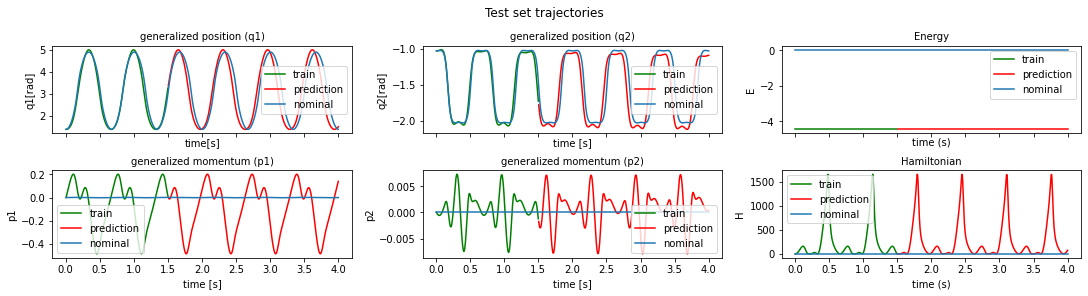

In [188]:
plot_furuta_hat_nom(test_loader, t_max=300,
                     title = 'Test set trajectories', file_path=PATH+'img/test_set_traj.png')

In [189]:
train_loader_2, test_loader_2 = load_data_device(time_steps=2000, num_trajectories=2, 
                                             C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1)

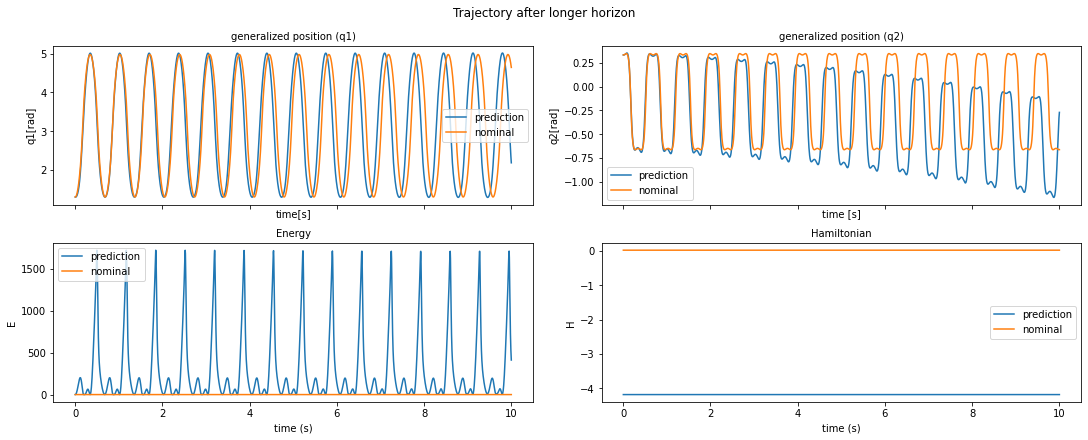

In [190]:
plot_longer_horizon_furuta(test_loader_2,t1=0,t2=2000, title = 'Trajectory after longer horizon',
                           file_path=PATH+'img/longer_horizon.png')

#### Horizon method : Symoden

In [175]:
def change_data_shape(q1, p1, q2, p2, derivatives):
    
    a = torch.stack((q1, p1, q2, p2),dim=2) # [ nb_trajectoires, nb_time_steps, (q1,p1,q2,p2)]
    b = torch.permute(derivatives,(0,1,2)) # [nb_trajectoires, nb_time_steps, (dp1/dt,dq2/dt,dp2/dt)]
    x = torch.cat((a,b),dim=2)
    # x is now [nb_trajectoires, nb_time_steps, (q1,p1,q2,p2,dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
    return x

In [249]:
def arrange_data(x, t, num_points=2):
    '''
    Arrange data to feed into neural ODE in small chunks
    Converted to pytorch from the numpy version in the Symoden repository
    '''
    assert num_points>=2 and num_points<=len(t) 
    x_stack = []
    for i in range(num_points):
        #print('i',i)
        if i < num_points-1:
            #print(x[:, i:-num_points+i+1,:,:].shape)
            x_stack.append(x[:, i:-num_points+i+1, :])
        else:
            x_stack.append(x[:, i:, :])
    x_stack = torch.stack(x_stack, axis=1)

    x_stack = torch.reshape(x_stack, 
                (num_points,-1,x.shape[2]))
    t_eval = t[0:num_points] 
    return x_stack, t_eval

In [285]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=20, num_trajectories=10, y0=None, noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)

In [315]:
# to illustrate how the function works we use x_new
x_new = change_data_shape(torch.ones([10, 20]), torch.ones([10, 20])*2, torch.ones([10, 20])*3, torch.ones([10, 20])*4, derivatives) 
# only take q1, p1, q2, p2 states : 
x_new = x_new[:,:,:]
x_arranged, t_eval_arranged = arrange_data(x_new, t_eval, num_points=10)

In [316]:
print(x_new.shape)
x_new[0,0:3,:]

torch.Size([10, 20, 8])


tensor([[ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0143,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000, -0.5628, -0.0142,  0.0804, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000, -1.1258, -0.0142,  0.1628, -0.0000]])

In [317]:
print(x_arranged.shape)
x_arranged[:,0,:] # a new trajectory of length num_points made by slicing longer trajectories

torch.Size([10, 110, 8])


tensor([[ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0143,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000,  0.0141,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0139,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000,  0.0063,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0128,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0149,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000,  0.0100,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0050,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0077,  0.0000, -0.0000],
        [ 1.0000,  2.0000,  3.0000,  4.0000,  0.0000, -0.0106,  0.0000, -0.0000]])

In [280]:
q1.shape

torch.Size([10, 20])

In [ ]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=300, num_trajectories=100, y0=None, noise_std=0.0, 
                   u=0.0,C_q1=0.0, C_q2=0.0)
print(q1.t().shape)
print(energy.t().shape)
print(torch.permute(derivatives,(0,2,1)).shape)
print(t_eval.shape)

In [ ]:
def load_data_device_horizon(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1,num_points=30):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(time_steps=time_steps, 
                    num_trajectories=num_trajectories, y0=None, noise_std=0.0, 
                    u=0.0,C_q1=0.0, C_q2=0.0)

    x_new = change_data_shape(q1, p1, q2, p2, derivatives)
    x_arranged, t_eval_arranged = arrange_data(x_new, t_eval, num_points=num_points)
    x_arranged = torch.permute(x_arranged,(1,0,2))
    q1_new, p1_new, q2_new, p2_new = torch.chunk(x_arranged[:,:,0:4],4,dim=2)
    derivatives_new = x_arranged[:,:,4:8]

    q1 = q1_new.squeeze(dim=2).to(device)
    p1 = p1_new.squeeze(dim=2).to(device)
    q2 = q2_new.squeeze(dim=2).to(device)
    p2 = p2_new.squeeze(dim=2).to(device)


    energy = energy.to(device)
    derivatives = derivatives_new.to(device)
    t_eval = t_eval_arranged.to(device)

    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                        shuffle = True, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_data_device_horizon(time_steps=40, num_trajectories=10, C_q1=0.0, C_q2=0.0, 
                     noise_std=0.0, coord_type='hamiltonian', proportion=0.5, batch_size=1,num_points=30)

In [71]:
def train_moving_horizon(model, epochs = 20):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3
    Ts = 0.005
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    w=torch.tensor([0.1,0.1,1.0,1.0], device=device)

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()
        horizon = select_horizon(step)
        # horizon = -1
        for x, t_eval in iter(train_loader):
            
            t_eval = t_eval[0,:horizon]

            train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            

            train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss = train_loss + train_loss_mini

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad() 

        t2 = time.time()
        train_time = t2-t1

        if test_loader: 
            if not (step%10): # run validation every 10 steps
                for x, t_eval in iter(test_loader):
                    # run test data
                    t_eval = t_eval[0,:horizon]
   
                    test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')      
                    test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                    test_loss = test_loss + test_loss_mini
                test_time = time.time()-t2
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                      .format(step, train_time, train_loss.item(), test_loss.item(),test_time))
                stats['test_loss'].append(test_loss.item())
                
            else:
                print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                      .format(step, train_time, train_loss.item()))
        
        # logging
        stats['train_loss'].append(train_loss.item())
        
    return stats

# Autoencoder

In [ ]:
def train_only_ae(autoencoder, 
                  model,
                  train_loader, 
                  test_loader, 
                  epochs,
                  horizon,
                  lr = 1e-3): 
    alpha = 1.0
    beta = 1.0
    gamma = 1.0

    
    Ts = 0.005
    # params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(autoencoder.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()

        autoencoder.eval()
        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # Train the autoencoder alone for the first epochs

            p_hat, q_dot_hat = autoencoder(x[:, :horizon, :])
            # autoencoder only outputs q_dot_hat states
            # print(q_dot_hat.shape)

            train_loss_batch = L2_loss(q_dot_hat, x[:, :horizon, [1,3]])
            # print(train_loss_batch.shape,train_loss_batch.item(),x[:, :horizon, [1,3]].shape)
            # print(train_loss_batch)

            train_loss = train_loss + train_loss_batch.item() 
            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad() # set_to_none=True
            if not step%50:
                plt.plot(x[0,:,1],label='nominal')
                plt.plot(q_dot_hat[0,:,0].detach(),label='autenc')
                plt.legend()
                plt.show()

        t2 = time.time()
        train_time = t2-t1
        if not step%20:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                    .format(step, train_time, train_loss))

        # logging
        stats['train_loss'].append(train_loss)

    return stats